<a href="https://colab.research.google.com/github/SriharshavardhanChadaram/fake-news-detector-/blob/main/VRV_AIR_CONSUMPTION_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Enter forecast horizon (days): 10
Enter the number of outdoor units off (0-10): 2
Enter the number of indoor units off (0-100): 3


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


,Date,Predicted Power (kWh),Predicted Outdoor Temp (°C),Predicted Room Temp (°C),Units Off
0,2025-09-10,337.001875,36.812818,24.291460,"2 Outdoor Unit(s), 3 Indoor Unit(s)"
1,2025-09-11,326.416881,36.890551,24.320412,"2 Outdoor Unit(s), 3 Indoor Unit(s)"
2,2025-09-12,320.628684,36.712258,24.439377,"2 Outdoor Unit(s), 3 Indoor Unit(s)"
3,2025-09-13,314.361429,36.541448,24.551975,"2 Outdoor Unit(s), 3 Indoor Unit(s)"
4,2025-09-14,308.409192,36.347059,24.661265,"2 Outdoor Unit(s), 3 Indoor Unit(s)"
5,2025-09-15,304.676707,36.212844,24.754434,"2 Outdoor Unit(s), 3 Indoor Unit(s)"
6,2025-09-16,301.940479,36.096124,24.835306,"2 Outdoor Unit(s), 3 Indoor Unit(s)"
7,2025-09-17,298.164317,35.907312,24.917775,"2 Outdoor Unit(s), 3 Indoor Unit(s)"
8,2025-09-18,294.804881,35.703672,24.995823,"2 Outdoor Unit(s), 3 Indoor Unit(s)"
9,2025-09-19,291.008604,35.455680,25.070480,"2 Outdoor Unit(s), 3 Indoor Unit(s)"


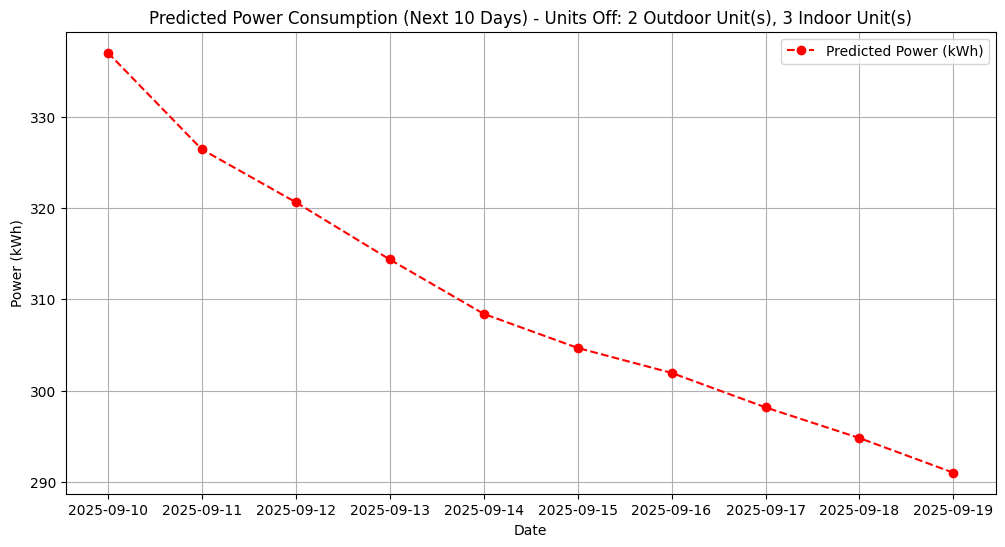

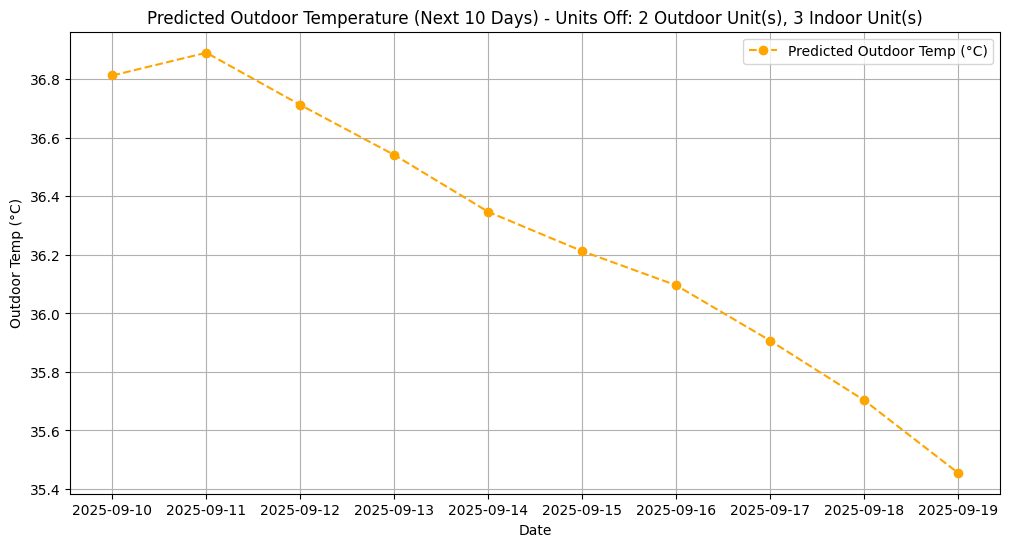

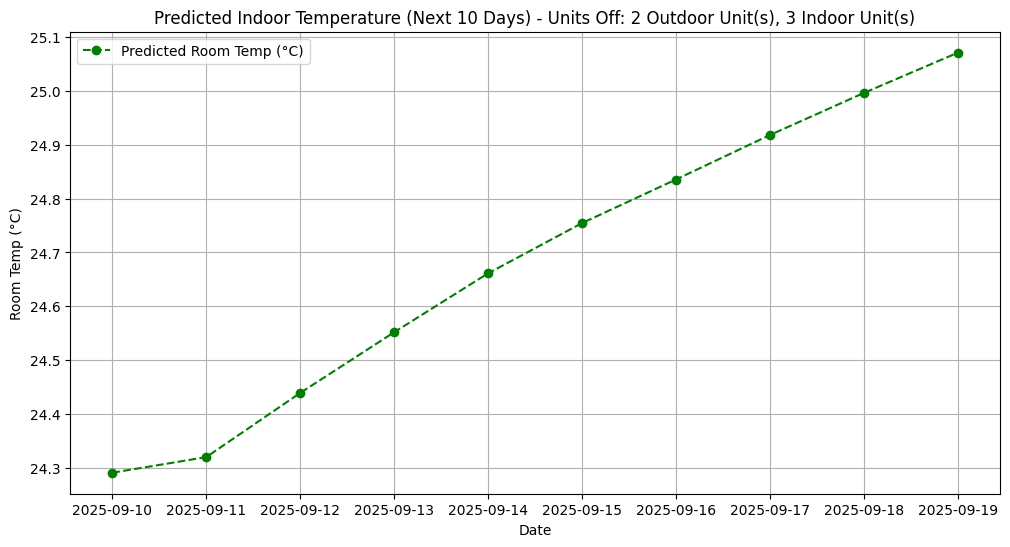

In [54]:
# ===============================
# 📌 VRV LSTM Forecast
#    (Multi-output: Power + Indoor Temp + Outdoor Temp)
#    (Includes unit-specific power features and unit-off scenarios)
# ===============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Deep learning
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


# -----------------------------
# 1. Generate Synthetic Dataset
# -----------------------------
base_date = pd.to_datetime("2025-09-09")
# Update base_values to reflect 10 outdoor and 100 indoor units
base_values = {
    **{f"Outdoor_Unit{i}_Power_kW": 0.7 for i in range(1, 11)}, # Assuming 10 outdoor units with base power 0.7 kW each
    **{f"Indoor_Unit{i}_Power_kW": 0.05 for i in range(1, 101)}, # Assuming 100 indoor units with base power 0.05 kW each
    "Outdoor Temp (°C)": 35.4,
    "Room Temp (°C)": 24.67,
    "Humidity (%)": 52.63,
    "CO₂ (ppm)": 605.32,
    "Baseline_Power_kW": 0.5 # Add a baseline power
}

np.random.seed(42)
days = 90
dates = [base_date - pd.Timedelta(days=i) for i in range(days)][::-1]

synthetic_data = []
for i, d in enumerate(dates):
    weekday = d.weekday()
    weekly_factor = 1 + np.random.uniform(0.05, 0.10) if weekday < 5 else 1 - np.random.uniform(0.10, 0.15)
    seasonal_temp = base_values["Outdoor Temp (°C)"] + (i * 0.05)

    row = {
        "Date": d,
        "Outdoor Temp (°C)": seasonal_temp + np.random.normal(0, 1.5),
        "Room Temp (°C)": base_values["Room Temp (°C)"] + np.random.normal(0, 1),
        "Humidity (%)": base_values["Humidity (%)"] + np.sin(i/7) * 5 + np.random.normal(0, 2),
        "CO₂ (ppm)": base_values["CO₂ (ppm)"] + np.random.normal(0, 40),
        "Unit_Off_Flag": 0 # Initially, set Unit_Off_Flag to 0 (all units on)
    }

    total_power_kw = base_values["Baseline_Power_kW"]
    for unit_type in ["Outdoor", "Indoor"]:
        for j in range(1, (11 if unit_type == "Outdoor" else 101)):
            unit_name = f"{unit_type}_Unit{j}_Power_kW"
            unit_power = base_values[unit_name] * weekly_factor * (1 + np.random.normal(0, 0.05))
            row[unit_name] = unit_power
            total_power_kw += unit_power

    row["Power Input (kW)"] = total_power_kw
    row["Total_Power_kWh"] = total_power_kw * 24 # Assuming daily data and constant power

    synthetic_data.append(row)

data = pd.DataFrame(synthetic_data)

# -----------------------------
# 2. Preprocessing
# -----------------------------
# Update features list to include all outdoor and indoor unit power features
outdoor_unit_features = [f"Outdoor_Unit{i}_Power_kW" for i in range(1, 11)]
indoor_unit_features = [f"Indoor_Unit{i}_Power_kW" for i in range(1, 101)]
features = ["Power Input (kW)", "Humidity (%)", "CO₂ (ppm)", "Unit_Off_Flag"] + outdoor_unit_features + indoor_unit_features

targets = ["Total_Power_kWh", "Outdoor Temp (°C)", "Room Temp (°C)"]

scaler = MinMaxScaler()
scaled = scaler.fit_transform(data[features + targets])
scaled_df = pd.DataFrame(scaled, columns=features + targets, index=data["Date"])


# -----------------------------
# 3. Create Sequences
# -----------------------------
def create_sequences(df, look_back=14):
    X, y = [], []
    values = df.values
    for i in range(len(df) - look_back):
        X.append(values[i:i+look_back, :len(features)])
        y.append(values[i+look_back, len(features):])
    return np.array(X), np.array(y)

look_back = 14
X, y = create_sequences(scaled_df, look_back)

split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


# -----------------------------
# 4. Build & Train Multi-Output LSTM
# -----------------------------
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(look_back, X.shape[2])),
    LSTM(32),
    Dense(len(targets))  # multi-output: Power + Temp + Temp
])
model.compile(optimizer="adam", loss="mse")
model.fit(X_train, y_train, epochs=40, batch_size=8,
          validation_data=(X_test, y_test), verbose=0)


# -----------------------------
# 5. Forecast Function (Power + Temp)
# -----------------------------
def forecast_vrv(days_ahead=30, units_off=None):
    if units_off is None:
        units_off = []

    forecast = []
    last_seq = X[-1]

    # Get the scaled representation of 0 for the relevant unit features
    # Create a dummy array with zeros for all original features and targets
    zero_values = np.zeros((1, len(features) + len(targets)))
    scaled_zero_values = scaler.transform(zero_values)[0]
    scaled_unit_off_flag_zero = scaled_zero_values[features.index("Unit_Off_Flag")]

    # Get the scaled representation of 1 for the Unit_Off_Flag
    one_unit_off_values = np.zeros((1, len(features) + len(targets)))
    one_unit_off_values[0, features.index("Unit_Off_Flag")] = 1
    scaled_one_unit_off_flag = scaler.transform(one_unit_off_values)[0][features.index("Unit_Off_Flag")]


    # Get the indices of the units to be turned off
    units_off_indices = [features.index(unit) for unit in units_off if unit in features]

    for _ in range(days_ahead):
        pred = model.predict(last_seq.reshape(1, look_back, X.shape[2]), verbose=0)
        forecast.append(pred[0])

        # Keep previous feature trend but add noise for realism
        new_features = last_seq[-1, :len(features)].copy() * (1 + np.random.normal(0, 0.01, size=len(features)))

        # Set the power input for units that are off to scaled zero and set the flag
        for idx in units_off_indices:
             new_features[idx] = scaled_zero_values[idx]

        # Set the Unit_Off_Flag based on whether any units are specified as off
        if units_off:
             new_features[features.index("Unit_Off_Flag")] = scaled_one_unit_off_flag
        else:
            new_features[features.index("Unit_Off_Flag")] = scaled_unit_off_flag_zero


        # new_row should only contain features for the next prediction input
        new_row_input = new_features # Use the modified features as the input for the next sequence

        last_seq = np.vstack([last_seq[1:], new_row_input])


    # Rescale the forecast targets
    # Create a dummy array with the same shape as the training data's scaled values
    dummy = np.zeros((len(forecast), len(features) + len(targets)))
    # Place the predicted target values into the target columns of the dummy array
    dummy[:, len(features):] = forecast
    # Inverse transform the dummy array. We only care about the rescaled targets.
    forecast_rescaled = scaler.inverse_transform(dummy)[:, len(features):]

    future_dates = pd.date_range(data["Date"].iloc[-1] + pd.Timedelta(days=1), periods=days_ahead)
    return future_dates, forecast_rescaled


# -----------------------------
# 6. User Input and Forecasting
# -----------------------------
try:
    days_ahead = int(input("Enter forecast horizon (days): "))
    if days_ahead <= 0:
        days_ahead = 7
        print("⚠️ Invalid input — defaulting to 7 days.")
except ValueError:
    days_ahead = 7
    print("⚠️ Invalid input — defaulting to 7 days.")

try:
    num_outdoor_off = int(input("Enter the number of outdoor units off (0-10): "))
    if num_outdoor_off < 0 or num_outdoor_off > 10:
        num_outdoor_off = 0
        print("⚠️ Invalid input for outdoor units — defaulting to 0.")
except ValueError:
    num_outdoor_off = 0
    print("⚠️ Invalid input for outdoor units — defaulting to 0.")

try:
    num_indoor_off = int(input("Enter the number of indoor units off (0-100): "))
    if num_indoor_off < 0 or num_indoor_off > 100:
        num_indoor_off = 0
        print("⚠️ Invalid input for indoor units — defaulting to 0.")
except ValueError:
    num_indoor_off = 0
    print("⚠️ Invalid input for indoor units — defaulting to 0.")


# Create the list of units to turn off based on user input
units_off_list = []
for i in range(1, num_outdoor_off + 1):
    units_off_list.append(f"Outdoor_Unit{i}_Power_kW")
for i in range(1, num_indoor_off + 1):
    units_off_list.append(f"Indoor_Unit{i}_Power_kW")


future_dates, forecast_rescaled = forecast_vrv(days_ahead, units_off=units_off_list)


# -----------------------------
# 7. Insights + Export
# -----------------------------
forecast_df = pd.DataFrame({
    "Date": future_dates,
    "Predicted Power (kWh)": forecast_rescaled[:, 0],
    "Predicted Outdoor Temp (°C)": forecast_rescaled[:, 1],
    "Predicted Room Temp (°C)": forecast_rescaled[:, 2]
})

# Create a descriptive string for the units that are off
units_off_description = []
if num_outdoor_off > 0:
    units_off_description.append(f"{num_outdoor_off} Outdoor Unit(s)")
if num_indoor_off > 0:
    units_off_description.append(f"{num_indoor_off} Indoor Unit(s)")

if units_off_description:
    forecast_df["Units Off"] = ", ".join(units_off_description)
else:
    forecast_df["Units Off"] = "None"

display(forecast_df)

# Save forecast
csv_file = "forecast_vrv_multi_custom_units_off.csv"
excel_file = "forecast_vrv_multi_custom_units_off.xlsx"
forecast_df.to_csv(csv_file, index=False)
forecast_df.to_excel(excel_file, index=False)
#files.download(csv_file)
#files.download(excel_file)

# -----------------------------
# 8. Graphs (Forecasted Trends)
# -----------------------------
# Ensure plt is imported
import matplotlib.pyplot as plt


# Create a descriptive string for the units that are off for the plot titles
units_off_description_plot = []
if num_outdoor_off > 0:
    units_off_description_plot.append(f"{num_outdoor_off} Outdoor Unit(s)")
if num_indoor_off > 0:
    units_off_description_plot.append(f"{num_indoor_off} Indoor Unit(s)")

if units_off_description_plot:
    plot_title_units_off = ", ".join(units_off_description_plot)
else:
    plot_title_units_off = "None"


plt.figure(figsize=(12,6))
plt.plot(future_dates, forecast_rescaled[:, 0], label="Predicted Power (kWh)", color="red", linestyle="--", marker="o")
plt.xlabel("Date"); plt.ylabel("Power (kWh)")
plt.title(f"Predicted Power Consumption (Next {days_ahead} Days) - Units Off: {plot_title_units_off}")
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,6))
plt.plot(future_dates, forecast_rescaled[:, 1], label="Predicted Outdoor Temp (°C)", color="orange", linestyle="--", marker="o")
plt.xlabel("Date"); plt.ylabel("Outdoor Temp (°C)")
plt.title(f"Predicted Outdoor Temperature (Next {days_ahead} Days) - Units Off: {plot_title_units_off}")
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,6))
plt.plot(future_dates, forecast_rescaled[:, 2], label="Predicted Room Temp (°C)", color="green", linestyle="--", marker="o")
plt.xlabel("Date"); plt.ylabel("Room Temp (°C)")
plt.title(f"Predicted Indoor Temperature (Next {days_ahead} Days) - Units Off: {plot_title_units_off}")
plt.legend(); plt.grid(True); plt.show()